# 1. Prepare Data

In [1]:
# import titanic dataset
import pandas as pd
titanic_dataset = pd.read_csv('data/titanic.csv')
titanic_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
titanic_dataset_filtered = titanic_dataset[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]
titanic_dataset_filtered_na = titanic_dataset_filtered.dropna()
# one hot encoding
titanic_dataset_filtered_na_encoded = pd.get_dummies(titanic_dataset_filtered_na, columns=['Sex', 'Embarked'], dtype=float)
label = titanic_dataset_filtered_na_encoded['Survived']
features = titanic_dataset_filtered_na_encoded.drop(['Survived'], axis=1)  

In [3]:
# extract numpy arrays to create tensors
features = features.values
label = label.values

In [4]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=0)

# 2. Train neural network

In [5]:
# set processing device
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [6]:
tensor_feature_train = torch.Tensor(feature_train).float().to(device)
tensor_feature_test = torch.Tensor(feature_test).float().to(device)
tensor_label_train = torch.Tensor(label_train).long().to(device)
tensor_label_test = torch.Tensor(label_test).long().to(device)

In [7]:
import torch
torch.manual_seed(0) # ensure reproducibiltiy
import torch.nn as nn

class DeepNeuralNetwork(nn.Module):
    def __init__(self):

        super(DeepNeuralNetwork, self).__init__()

        # layer definitions
        self.hidden1 = nn.Linear(10, 5)
        self.output = nn.Linear(5, 2)

    def forward(self, x):
        
        # forward pass
        z1 = self.hidden1(x)
        a1 = torch.relu(z1)
        z2 = self.output(a1)
        # no softmax for output layer
        return z2

In [8]:
dnn = DeepNeuralNetwork()
dnn.to(device)
dnn.train()

DeepNeuralNetwork(
  (hidden1): Linear(in_features=10, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=2, bias=True)
)

## Training Proceedure

In [9]:
no_epochs = 200
learning_rate = 0.001

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dnn.parameters(), lr=learning_rate)

losses = []
for epoch in range(no_epochs):
    optimizer.zero_grad()

    # forward pass
    label_pred = dnn(tensor_feature_train) # predict on all datapoints (batch gradient descend)

    # backward pass
    loss = loss_func(label_pred, tensor_label_train)
    loss.backward() # calculate gradients
    optimizer.step() # update Weights using gradients

    losses.append(loss.item())
    if epoch % 20 == 0:
        print(f"Loss in epoch {epoch} is {loss.item()}")


Loss in epoch 0 is 2.679896354675293
Loss in epoch 20 is 0.9348610043525696
Loss in epoch 40 is 0.7034342885017395
Loss in epoch 60 is 0.6687774658203125
Loss in epoch 80 is 0.6559247970581055
Loss in epoch 100 is 0.6481152176856995
Loss in epoch 120 is 0.6426729559898376
Loss in epoch 140 is 0.6388674378395081
Loss in epoch 160 is 0.6362173557281494
Loss in epoch 180 is 0.6343756914138794


Text(0, 0.5, 'loss')

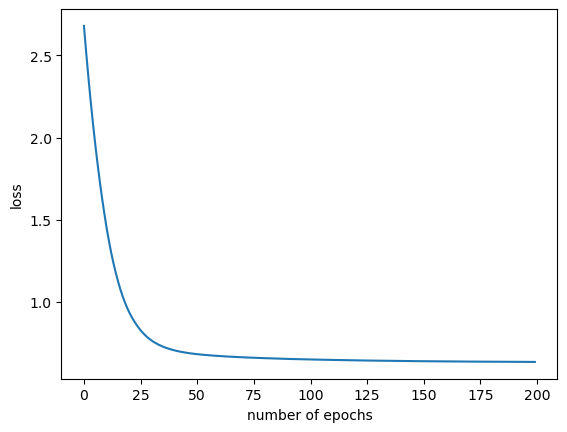

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(0, no_epochs), losses)
plt.xlabel('number of epochs')
plt.ylabel('loss')

## Prediction and accuracy

In [11]:
dnn.eval() # set model to evaluation mode
label_pred = dnn(tensor_feature_test)
predicted = torch.argmax(label_pred.data, 1)
correct = (predicted == tensor_label_test).sum().item()
accuracy = correct / len(tensor_feature_test)

print(f"Accuarcy is {100. * accuracy}%")

Accuarcy is 62.93706293706294%


# 3. Check for overfitting 

In [12]:
# reset model
dnn = DeepNeuralNetwork()
dnn.to(device)
dnn.train()

DeepNeuralNetwork(
  (hidden1): Linear(in_features=10, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=2, bias=True)
)

In [13]:
no_epochs = 200
learning_rate = 0.001

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dnn.parameters(), lr=learning_rate)


losses = []
accuracy_tests = []
accuracy_trains = []
for epoch in range(no_epochs):
    optimizer.zero_grad()

    # forward pass
    label_pred = dnn(tensor_feature_train) # predict on all datapoints (batch gradient descend)

    # backward pass
    loss = loss_func(label_pred, tensor_label_train)
    loss.backward() # calculate gradients
    optimizer.step() # update Weights using gradients

    losses.append(loss.item())

    # test accuracy
    predicted = torch.argmax(label_pred.data, 1)
    correct = (predicted == tensor_label_train).sum().item()
    accuracy_train = correct / len(tensor_feature_train)
    
    dnn.eval() # set model to evaluation mode
    label_pred = dnn(tensor_feature_test)
    dnn.train() # set model to training mode
    predicted = torch.argmax(label_pred.data, 1)
    correct = (predicted == tensor_label_test).sum().item()
    accuracy_test = correct / len(tensor_feature_test)

    accuracy_tests.append(accuracy_test)
    accuracy_trains.append(accuracy_train)

    if epoch % 20 == 0:
        print(f"Loss in epoch {epoch} is {loss.item()}")

Loss in epoch 0 is 1.0894228219985962
Loss in epoch 20 is 0.7266775369644165
Loss in epoch 40 is 0.710625410079956
Loss in epoch 60 is 0.7017519474029541
Loss in epoch 80 is 0.6950086355209351
Loss in epoch 100 is 0.6891719698905945
Loss in epoch 120 is 0.6838389039039612
Loss in epoch 140 is 0.6789277195930481
Loss in epoch 160 is 0.6744047999382019
Loss in epoch 180 is 0.6701847910881042


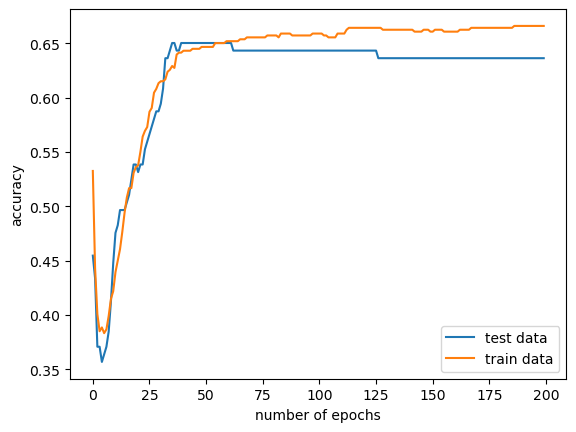

In [14]:
## plot accuracy
fig = plt.figure()
plt.plot(range(0, no_epochs), accuracy_tests, label = 'test data')
plt.plot(range(0, no_epochs), accuracy_trains, label = 'train data')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()